In [2]:
from dictionary_learning import CrossCoder
from torch.nn.functional import cosine_similarity
import torch as th
import plotly.express as px
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
th.set_grad_enabled(False)

In [5]:
checkpoint_root = Path("../checkpoints/")

In [6]:
big_boy_path = checkpoint_root / "bigboy-mu1.0e-02-lr1e-04" / "ae_90000.pt"

coder = CrossCoder.from_pretrained(big_boy_path)


In [18]:
results = Path("../results/eval_crosscoder")

layer_5_results = results / "bigboy-mu1.0e-02-lr1e-04_ae_90000_layer_5"
layer_13_results = results / "bigboy-mu1.0e-02-lr1e-04_ae_90000_layer_13"
layer_20_results = results / "bigboy-mu1.0e-02-lr1e-04_ae_90000_layer_20"

results_paths = {
    5: layer_5_results,
    13: layer_13_results,
    20: layer_20_results,
}

base_only_features = {
    i: th.load(results_paths[i] / "data" / f"only_base_decoder_feature_indices.pt", weights_only=True)
    for i in [5, 13, 20]
}
it_only_features = {
    i: th.load(results_paths[i] / "data" / f"only_it_decoder_feature_indices.pt", weights_only=True)
    for i in [5, 13, 20]
}

shared_features = {
    i: th.load(results_paths[i] / "data" / f"shared_decoder_feature_indices.pt", weights_only=True)
    for i in [5, 13, 20]
}


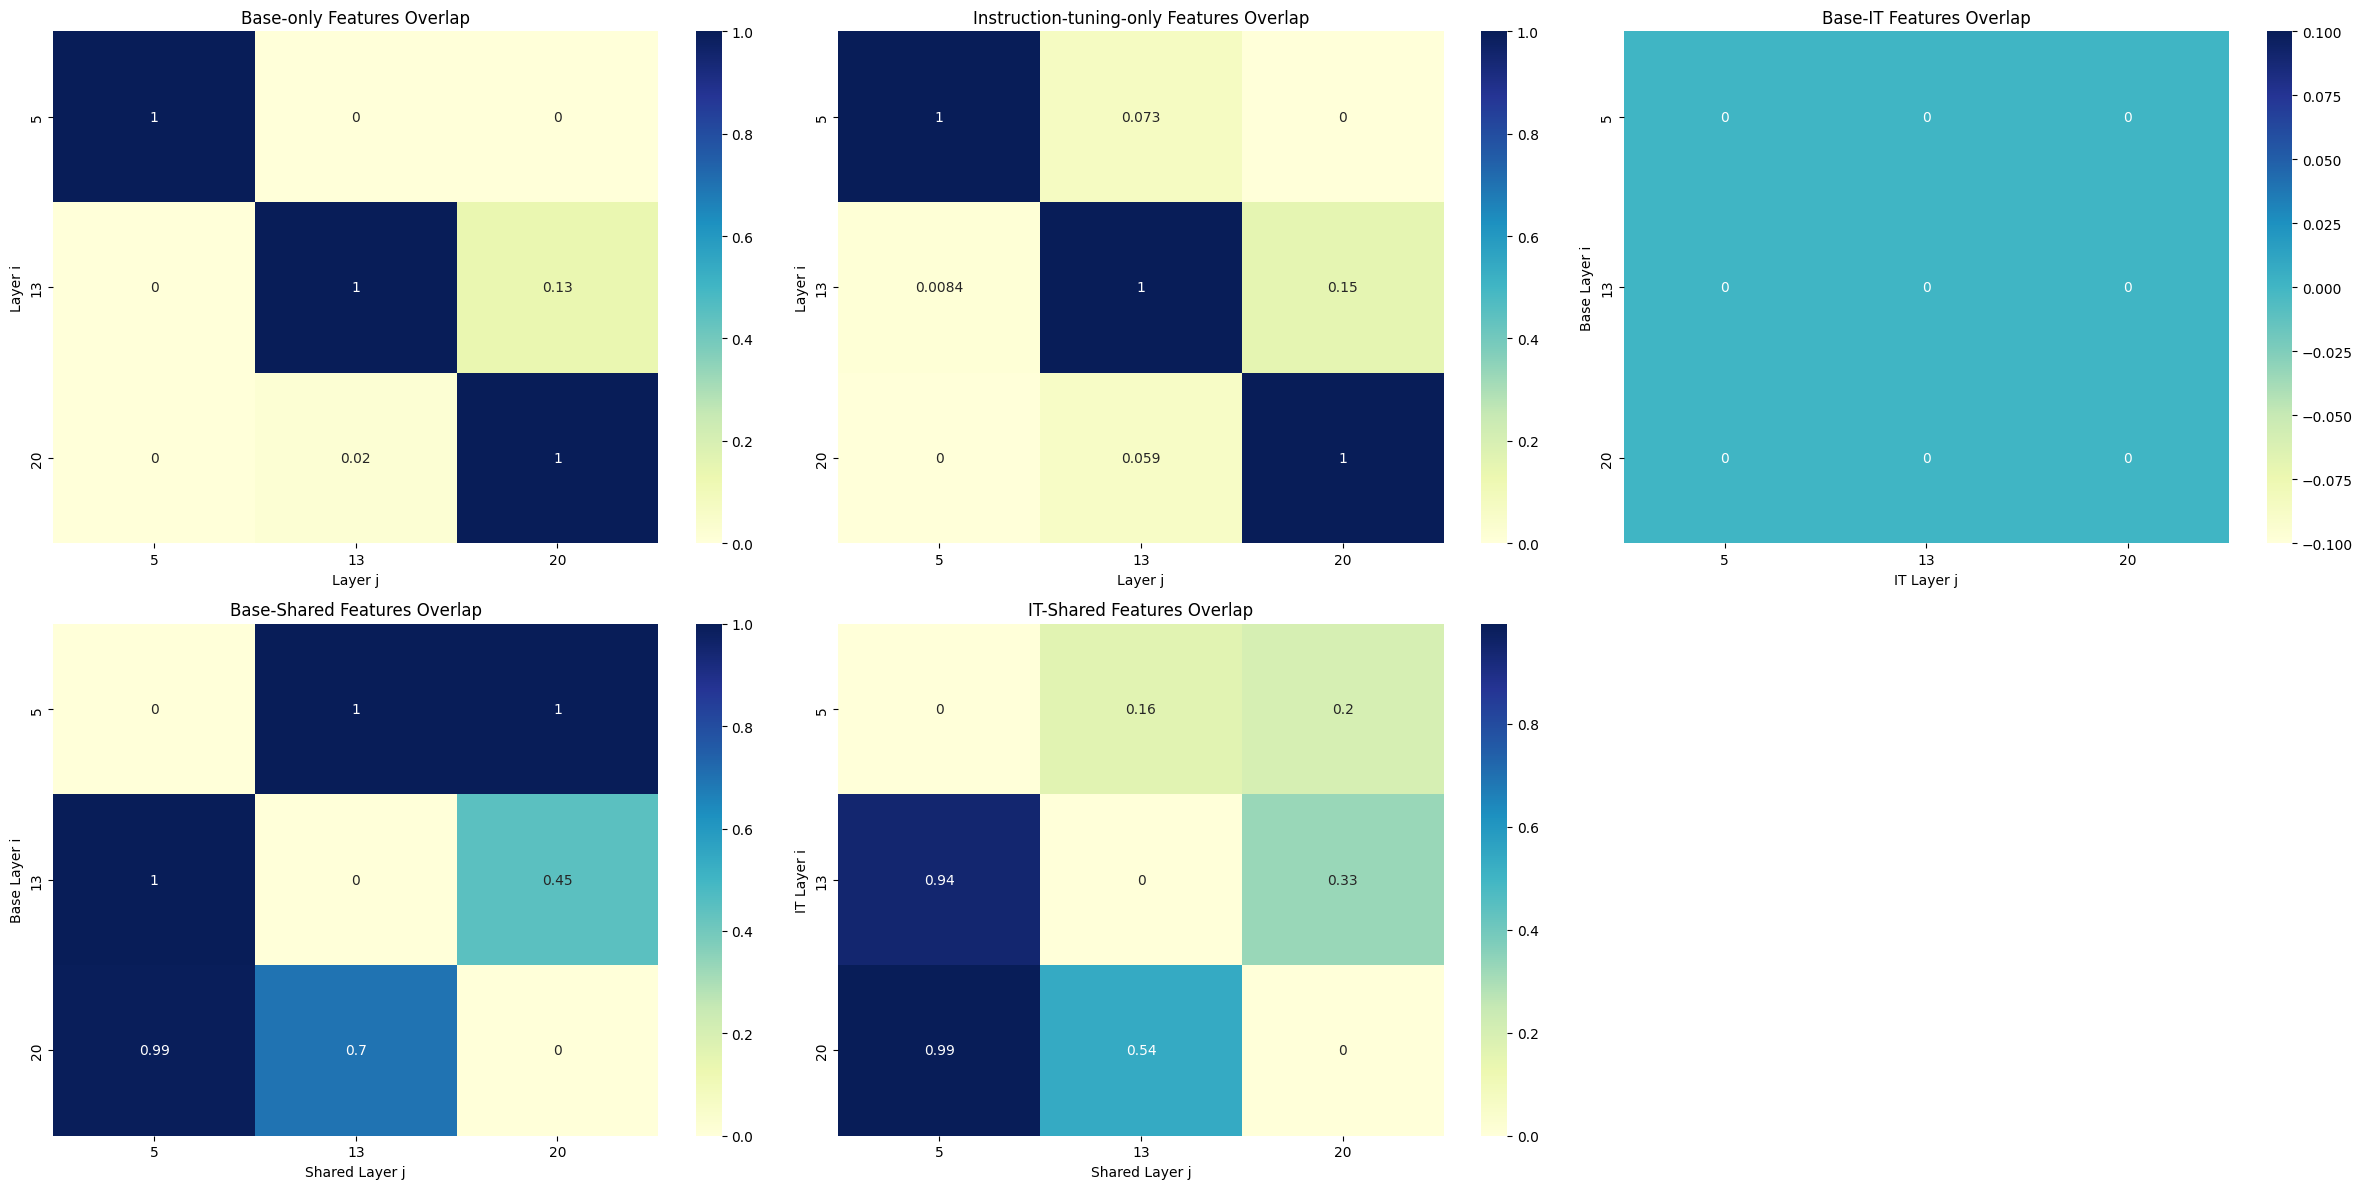

In [19]:
# Check overlap between layers with heatmap layer-by-layer of i,j = frac of features in i that are also in j
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_overlap(features_i, features_j):
    return len(set(features_i.tolist()) & set(features_j.tolist())) / len(features_i)

layers = [5, 13, 20]
n_layers = len(layers)

# Calculate overlap for base_only_features
base_overlap = np.zeros((n_layers, n_layers))
for i, layer_i in enumerate(layers):
    for j, layer_j in enumerate(layers):
        base_overlap[i, j] = calculate_overlap(base_only_features[layer_i], base_only_features[layer_j])

# Calculate overlap for it_only_features
it_overlap = np.zeros((n_layers, n_layers))
for i, layer_i in enumerate(layers):
    for j, layer_j in enumerate(layers):
        it_overlap[i, j] = calculate_overlap(it_only_features[layer_i], it_only_features[layer_j])

# Calculate overlap between base and it features
base_it_overlap = np.zeros((n_layers, n_layers))
for i, layer_i in enumerate(layers):
    for j, layer_j in enumerate(layers):
        base_it_overlap[i, j] = calculate_overlap(base_only_features[layer_i], it_only_features[layer_j])

# Calculate overlap between base and shared features
base_shared_overlap = np.zeros((n_layers, n_layers))
for i, layer_i in enumerate(layers):
    for j, layer_j in enumerate(layers):
        base_shared_overlap[i, j] = calculate_overlap(base_only_features[layer_i], shared_features[layer_j])

# Calculate overlap between it and shared features
it_shared_overlap = np.zeros((n_layers, n_layers))
for i, layer_i in enumerate(layers):
    for j, layer_j in enumerate(layers):
        it_shared_overlap[i, j] = calculate_overlap(it_only_features[layer_i], shared_features[layer_j])

# Create subplots for all overlaps
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 12))

sns.heatmap(base_overlap, annot=True, cmap="YlGnBu", ax=ax1)
ax1.set_title("Base-only Features Overlap")
ax1.set_xticklabels(layers)
ax1.set_yticklabels(layers)
ax1.set_xlabel("Layer j")
ax1.set_ylabel("Layer i")

sns.heatmap(it_overlap, annot=True, cmap="YlGnBu", ax=ax2)
ax2.set_title("Instruction-tuning-only Features Overlap")
ax2.set_xticklabels(layers)
ax2.set_yticklabels(layers)
ax2.set_xlabel("Layer j")
ax2.set_ylabel("Layer i")

sns.heatmap(base_it_overlap, annot=True, cmap="YlGnBu", ax=ax3)
ax3.set_title("Base-IT Features Overlap")
ax3.set_xticklabels(layers)
ax3.set_yticklabels(layers)
ax3.set_xlabel("IT Layer j")
ax3.set_ylabel("Base Layer i")

sns.heatmap(base_shared_overlap, annot=True, cmap="YlGnBu", ax=ax4)
ax4.set_title("Base-Shared Features Overlap")
ax4.set_xticklabels(layers)
ax4.set_yticklabels(layers)
ax4.set_xlabel("Shared Layer j")
ax4.set_ylabel("Base Layer i")

sns.heatmap(it_shared_overlap, annot=True, cmap="YlGnBu", ax=ax5)
ax5.set_title("IT-Shared Features Overlap")
ax5.set_xticklabels(layers)
ax5.set_yticklabels(layers)
ax5.set_xlabel("Shared Layer j")
ax5.set_ylabel("IT Layer i")

# Remove the unused subplot
fig.delaxes(ax6)

plt.tight_layout()
plt.show()


In [15]:
print(it_only_features[13].shape)
print(it_only_features[20].shape)
print(sum([i in it_only_features[20] for i in it_only_features[13]]))



torch.Size([475])
torch.Size([1242])
73
